<a href="https://colab.research.google.com/github/kevlord997/ML_Algorithmic_Trading_Projects/blob/lesson-6/ML_Trading_L6_Class_Weight_and_Binary_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. INSTALLATION: We need imbalanced-learn for SMOTE
!pip install yfinance pandas ta scikit-learn imbalanced-learn --quiet

# 2. IMPORTS: Grouping related tools
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier # Our new model!
from imblearn.over_sampling import SMOTE # Our imbalance fix!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# 3. DATA RETRIEVAL (Review): Downloading the time series data
ticker = "SPY"
spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
spy_data.columns = spy_data.columns.get_level_values(0)
spy_data.rename(columns={'Close': 'Adj Close'}, inplace=True)

  Preparing metadata (setup.py) ... done


/tmp/ipython-input-4039270284.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [2]:
# 4. FEATURE ENGINEERING: Creating the X variables

# Simple Moving Averages (Laggards - Measure Trend)
spy_data['SMA_20'] = spy_data['Adj Close'].rolling(window=20).mean()
spy_data['SMA_100'] = spy_data['Adj Close'].rolling(window=100).mean()

# Relative Strength Index (Oscillator - Measure Momentum/Condition)
# RSI is one of the most critical trading indicators.
rsi_indicator = RSIIndicator(close=spy_data['Adj Close'], window=14)
spy_data['RSI'] = rsi_indicator.rsi()

# Momentum (Directly measures price change over N periods)
spy_data['MOM'] = spy_data['Adj Close'].diff(periods=10)

# 5. TARGET VARIABLE (Deep Dive): The Y variable, our future prediction
N = 5 # Predict 5 days in the future
spy_data['Future_Price'] = spy_data['Adj Close'].shift(-N)

# np.where is a powerful function: If condition is true, return 1, else return 0.
spy_data['Target'] = np.where(spy_data['Future_Price'] > spy_data['Adj Close'], 1, 0)

# Create the SMA Cross Feature (Binary Signal)
# If SMA_20 > SMA_100, the result is True (1), else False (0)
spy_data['SMA_Cross_Signal'] = np.where(spy_data['SMA_20'] > spy_data['SMA_100'], 1, 0)

# Define the new feature set (X)
# We use the raw SMAs and the new binary signal.
X = spy_data[['SMA_20', 'SMA_100', 'RSI', 'MOM', 'SMA_Cross_Signal']]
Y = spy_data['Target']

# Final cleanup (if necessary)
spy_data.dropna(inplace=True)

print(f"New Features: {X.columns.tolist()}")



# Deep Dive Question 1: Why is it crucial to drop NaN values?
# (Answer: NaN values represent incomplete data points where one or more features/target cannot be calculated. ML algorithms cannot handle them.)

New Features: ['SMA_20', 'SMA_100', 'RSI', 'MOM', 'SMA_Cross_Signal']


In [3]:
# 6. TIME SERIES SPLIT (Deep Dive): Maintaining chronological order
split_point = int(len(X) * 0.8)

# Why use slicing ([:split_point]) instead of train_test_split(..., shuffle=True)?
# (Answer: To prevent data leakage. Shuffling a time series allows the model to "see" the future when training, leading to artificially inflated, useless accuracy.)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

# 7. FEATURE SCALING (Deep Dive): Standardizing the feature ranges
scaler = StandardScaler()
# Why fit_transform on train, but only transform on test?
# (Answer: The model must learn the standard deviation and mean *only* from the training data. Applying the transform to the test set ensures the test data is treated as 'new, unseen' data, preventing information leakage.)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- Random Forest Model Evaluation (Class Weighted) ---
Accuracy on Test Set: 0.4879

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42       296
           1       0.56      0.52      0.54       409

    accuracy                           0.49       705
   macro avg       0.48      0.48      0.48       705
weighted avg       0.49      0.49      0.49       705



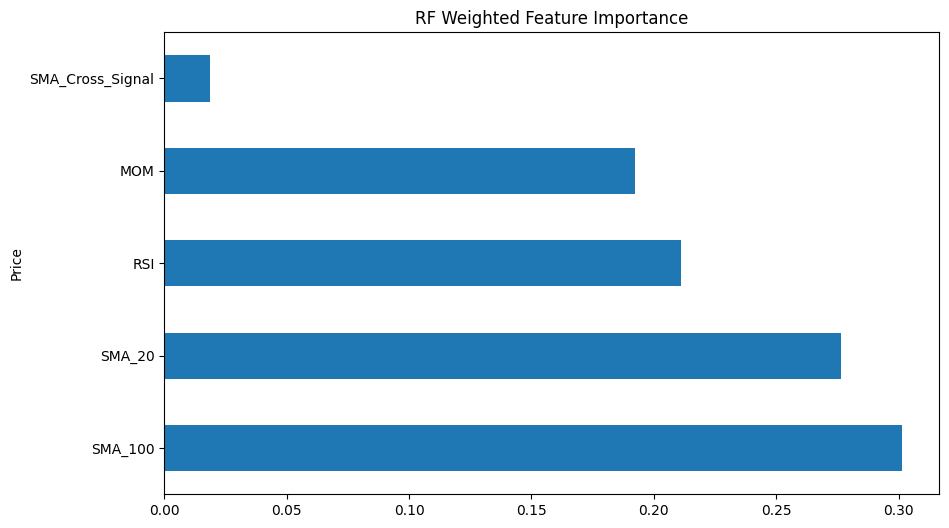

In [4]:
# Re-split and scale the data (X_train_scaled, X_test_scaled)
# ... (Code for 80/20 chronological split and StandardScaler) ...

# 1. MODEL TRAINING: Random Forest with Class Weights
# class_weight='balanced' tells the model to weight the minority class higher.
rf_model_weighted = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced' # <-- The critical fix for imbalance!
)

# Train on the original (un-SMOTEd) scaled training data!
rf_model_weighted.fit(X_train_scaled, Y_train)

# 2. PREDICTION & EVALUATION
rf_Y_pred = rf_model_weighted.predict(X_test_scaled)

print(f"\n--- Random Forest Model Evaluation (Class Weighted) ---")
print(f"Accuracy on Test Set: {accuracy_score(Y_test, rf_Y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, rf_Y_pred))

# 3. Plot Feature Importance (to see if the Binary Feature is useful)
import matplotlib.pyplot as plt
feature_importances = pd.Series(rf_model_weighted.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', title='RF Weighted Feature Importance')
plt.show()

In [5]:
from sklearn.metrics import roc_auc_score

# Get probability scores for Class 1 (Up)
Y_proba = rf_model_weighted.predict_proba(X_test_scaled)[:, 1]

# Calculate and print ROC AUC
roc_auc = roc_auc_score(Y_test, Y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.4571
